combine data

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from flaml import AutoML

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
file_names = ['003_2006_2080_352_360.nc','004_2006_2080_352_360.nc','005_2006_2080_352_360.nc',
              '006_2006_2080_352_360.nc','007_2006_2080_352_360.nc','008_2006_2080_352_360.nc']
datasets = [xr.open_dataset(f).expand_dims("source").assign_coords(source=[f]) for f in file_names]
combined_dataset = xr.concat(datasets, dim="source")
combined_dataset

D:\Anaconda3\anaconda\envs\myenv\Lib\site-packages\ecmwflibs\__init__.py:81: UserWarning: DLL load failed while importing _ecmwflibs: 找不到指定的程序。
  warnings.warn(str(e))
D:\Anaconda3\anaconda\envs\myenv\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 390MB
Dimensions:     (source: 6, time: 27374, lat: 11, lon: 6)
Coordinates:
  * lat         (lat) float32 44B 49.48 50.42 51.36 52.3 ... 57.02 57.96 58.9
  * lon         (lon) float32 24B 352.5 353.8 355.0 356.2 357.5 358.8
  * time        (time) object 219kB 2006-01-02 00:00:00 ... 2080-12-31 00:00:00
  * source      (source) <U24 576B '003_2006_2080_352_360.nc' ... '008_2006_2...
Data variables:
    TREFMXAV_U  (source, time, lat, lon) float32 43MB nan nan nan ... nan nan
    FLNS        (source, time, lat, lon) float32 43MB 76.48 78.5 ... 85.82 75.48
    FSNS        (source, time, lat, lon) float32 43MB 44.47 47.31 ... 10.29 9.14
    PRECT       (source, time, lat, lon) float32 43MB 1.158e-08 ... 6.275e-08
    PRSN        (source, time, lat, lon) float32 43MB 0.0 5.754e-23 ... 1.98e-13
    QBOT        (source, time, lat, lon) float32 43MB 0.005241 ... 0.004433
    TREFHT      (source, time, lat, lon) float32 43MB 284.4 284.2 ... 280.9
    UBOT        (source, time, lat, lon) float32 43MB 7.604 6.998 ... 6.827 7.6
    VBOT        (source, time, lat, lon) float32 43MB -3.69 -4.547 ... 5.44

In [3]:
combined_dataset.to_netcdf('combined_dataset.nc')

Data preprocessing and only Manchester

In [4]:
man_lat = 53.246075
man_lon = 357.5
ds = combined_dataset.sel(lat = man_lat, lon = man_lon, method = 'nearest')
#turn to dataframe
df = ds.to_dataframe().reset_index()

In [5]:
df = df.drop(['lat', 'lon'], axis=1)

In [6]:
#deal with time information
df['time'] = df['time'].astype(str)
df['time'] = pd.to_datetime(df['time'])
#Split time to year, month, day of year
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['dayofyear'] = df['time'].dt.dayofyear

#change source name
df['source'] = df['source'].str.split('_').str[0]
df['source'] = df['source'].astype(int)

In [7]:
df

,source,time,TREFMXAV_U,FLNS,FSNS,PRECT,PRSN,QBOT,TREFHT,UBOT,VBOT,year,month,dayofyear
0,3,2006-01-02,282.775848,41.925179,25.926952,4.663135e-09,4.781004e-17,0.004769,279.142883,3.878579,1.394184,2006,1,2
1,3,2006-01-03,284.471130,8.905806,10.946910,8.046593e-08,1.295726e-16,0.006271,281.148651,1.788157,3.821703,2006,1,3
2,3,2006-01-04,284.287964,16.511415,6.405902,2.910935e-09,4.094447e-16,0.005782,281.223785,0.804845,-2.299140,2006,1,4
3,3,2006-01-05,282.121094,29.948362,9.315041,7.432505e-11,0.000000e+00,0.004277,278.397675,-1.100267,-1.258029,2006,1,5
4,3,2006-01-06,280.890900,19.064156,7.941241,6.894238e-12,0.000000e+00,0.003990,278.063782,-0.706321,-0.938421,2006,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164239,8,2080-12-27,286.378754,17.438847,6.720299,3.892051e-08,7.616115e-15,0.006004,282.548523,2.741483,7.565282,2080,12,362
164240,8,2080-12-28,286.621307,26.986507,12.976557,2.301632e-07,6.722780e-16,0.005813,281.885712,4.295599,7.222901,2080,12,363
164241,8,2080-12-29,282.327393,41.652626,16.614481,2.653475e-08,1.264485e-15,0.004281,279.076965,3.328679,4.574871,2080,12,364
164242,8,2080-12-30,281.410248,56.226501,24.193817,1.709695e-08,2.954024e-17,0.004289,277.916626,2.779102,4.442761,2080,12,365


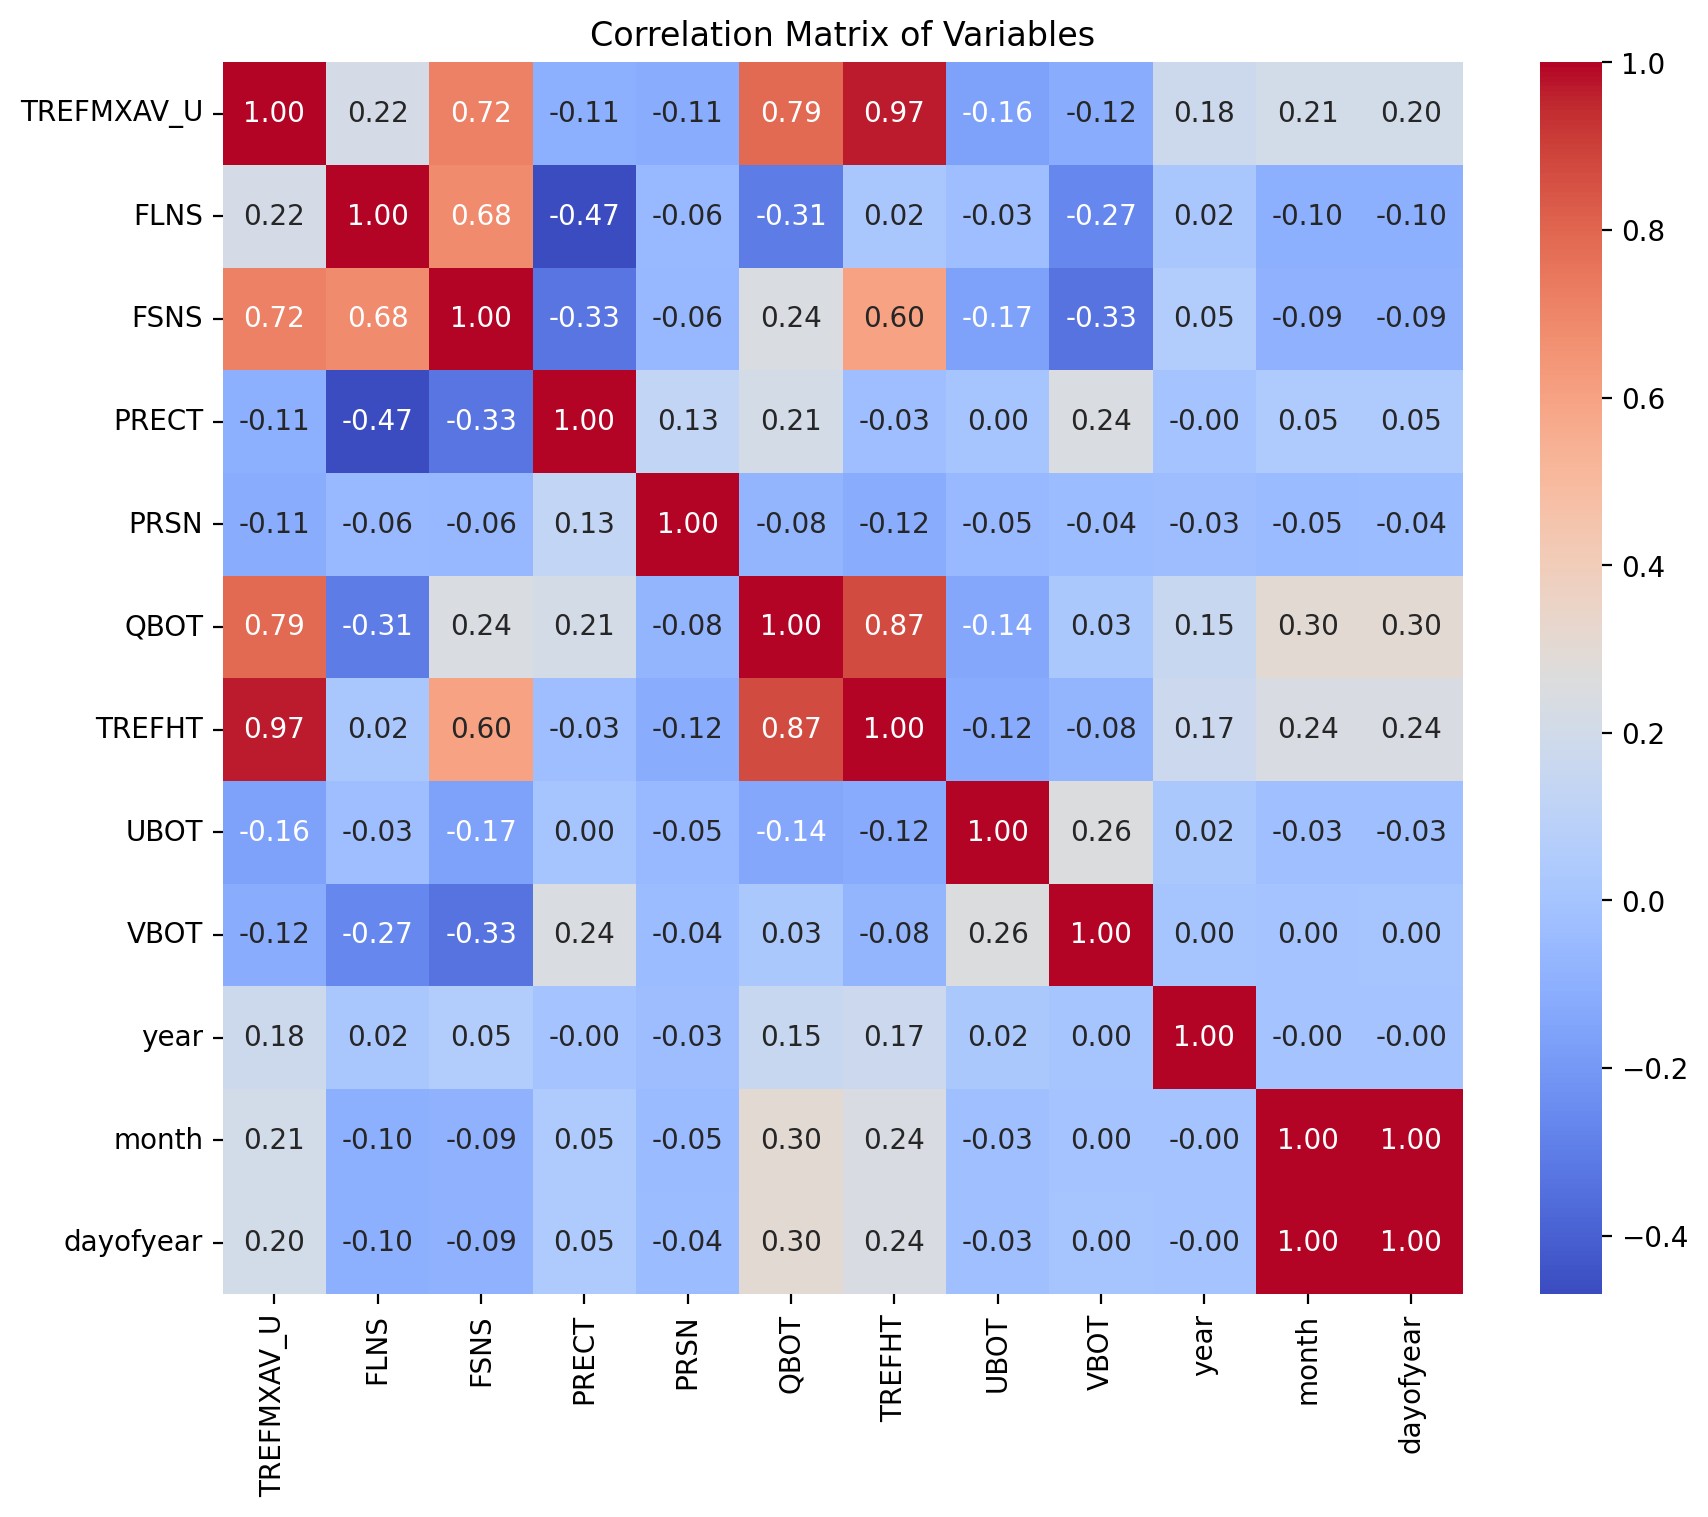

In [8]:
correlation_matrix = df.drop(['source','time'], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()

In [9]:
#split train and test
train = df[df['time'].dt.year < 2050]
test = df[df['time'].dt.year >= 2050]

In [10]:
test_3 = test[test['source'] == 3]
test_4 = test[test['source'] == 4]
test_5 = test[test['source'] == 5]
test_6 = test[test['source'] == 6]
test_7 = test[test['source'] == 7]
test_8 = test[test['source'] == 8]

In [11]:
#train and X_test
X_train = train.drop(['TREFMXAV_U','source','time'], axis=1) 
y_train = train['TREFMXAV_U']
X_test = test.drop(['TREFMXAV_U','source','time'], axis=1) 

In [12]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) 
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [13]:
y_pred = model.predict(X_test)
test['predict'] = y_pred

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\3744699403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict'] = y_pred


In [14]:
test_mean = test.groupby('time').mean().reset_index()
test_mean = test_mean.drop(['source'], axis=1)
test_mean

,time,TREFMXAV_U,FLNS,FSNS,PRECT,PRSN,QBOT,TREFHT,UBOT,VBOT,year,month,dayofyear,predict
0,2050-01-01,285.341278,29.458427,12.151672,7.680542e-08,1.036520e-15,0.005653,282.000793,4.784846,5.674775,2050.0,1.0,1.0,285.296325
1,2050-01-02,285.206696,30.211699,13.940259,1.075110e-07,7.055950e-15,0.005635,280.954559,2.585883,4.609480,2050.0,1.0,2.0,284.611283
2,2050-01-03,284.320740,37.802864,16.033865,8.329342e-08,2.721277e-15,0.004869,279.674713,2.405048,4.562534,2050.0,1.0,3.0,283.937983
3,2050-01-04,282.648041,44.336731,20.012060,5.740878e-08,3.395890e-16,0.004550,278.381256,3.669507,2.940760,2050.0,1.0,4.0,282.489393
4,2050-01-05,282.077789,48.498402,25.349710,1.484214e-08,3.921966e-15,0.004473,278.207855,3.288960,2.177729,2050.0,1.0,5.0,282.395910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11310,2080-12-27,284.036407,40.512272,20.476927,5.581414e-08,1.281563e-15,0.005026,279.936584,3.037782,1.580195,2080.0,12.0,362.0,283.998204
11311,2080-12-28,285.124451,32.158920,16.042503,6.051836e-08,1.442036e-16,0.005688,280.993378,4.157229,4.039726,2080.0,12.0,363.0,284.915623
11312,2080-12-29,284.690643,37.020874,15.653885,1.658894e-08,2.715376e-16,0.005063,280.913849,4.795880,3.623227,2080.0,12.0,364.0,284.375168
11313,2080-12-30,282.814789,40.770557,18.284941,3.031338e-08,2.530820e-15,0.004991,279.478363,2.251704,2.931198,2080.0,12.0,365.0,283.359285


In [15]:
y_test_mean = test_mean['TREFMXAV_U']
y_test_pred = test_mean['predict']

In [16]:
mse = mean_squared_error(y_test_mean, y_test_pred)
mae = mean_absolute_error(y_test_mean, y_test_pred)
r2 = r2_score(y_test_mean, y_test_pred)
rmse = sqrt(mse)

print(f'Validation Mean Squared Error (MSE): {mse}')
print(f'Validation Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Validation R-squared: {r2}')

Validation Mean Squared Error (MSE): 0.0855037012277417
Validation Mean Absolute Error (MAE): 0.23052538802230776
Root Mean Squared Error (RMSE): 0.29241015924167496
Validation R-squared: 0.9963486739533958


AutoML

All model

In [18]:
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 50,  # in seconds
    "metric": "r2",
    "task": "regression"
}
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

[flaml.automl.logger: 05-02 01:17:21] {1680} INFO - task = regression
[flaml.automl.logger: 05-02 01:17:21] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 05-02 01:17:21] {1789} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 05-02 01:17:21] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 05-02 01:17:21] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-02 01:17:21] {2345} INFO - Estimated sufficient time budget=2842s. Estimated necessary time budget=20s.
[flaml.automl.logger: 05-02 01:17:21] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.5118,	best estimator lgbm's best error=0.5118
[flaml.automl.logger: 05-02 01:17:21] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-02 01:17:21] {2392} INFO -  at 0.3s,	estimator lgbm's best error=0.5118,	best estimator lgbm's best error=0.5118
[flaml.automl.logger: 05-02 01:17:21] {2219} IN

In [20]:
print("best model:")
print(automl.model.estimator)

best model:
RandomForestRegressor(max_features=0.5951253949857058, max_leaf_nodes=2266,
                      n_estimators=168, n_jobs=-1, random_state=12032022)


In [21]:
y_pred = automl.predict(X_test)
test['predict'] = y_pred

test_mean = test.groupby('time').mean().reset_index()
test_mean = test_mean.drop(['source'], axis=1)

y_test_mean = test_mean['TREFMXAV_U']
y_test_pred = test_mean['predict']

mse = mean_squared_error(y_test_mean, y_test_pred)
mae = mean_absolute_error(y_test_mean, y_test_pred)
r2 = r2_score(y_test_mean, y_test_pred)
rmse = sqrt(mse)

print(f'AutoML Mean Squared Error (MSE): {mse}')
print(f'AutoML Mean Absolute Error (MAE): {mae}')
print(f'AutoML Root Mean Squared Error (RMSE): {rmse}')
print(f'AutoML R-squared: {r2}')

AutoML Mean Squared Error (MSE): 0.09199223864187234
AutoML Mean Absolute Error (MAE): 0.23885546781226638
AutoML Root Mean Squared Error (RMSE): 0.3033022232722212
AutoML R-squared: 0.9960715892737341


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\913663597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict'] = y_pred


Only RF

In [22]:
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 50,  # in seconds
    "metric": "r2",
    "task": "regression",
    "estimator_list": ["rf"]
}

automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

[flaml.automl.logger: 05-02 01:19:17] {1680} INFO - task = regression
[flaml.automl.logger: 05-02 01:19:17] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 05-02 01:19:17] {1789} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 05-02 01:19:17] {1901} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl.logger: 05-02 01:19:17] {2219} INFO - iteration 0, current learner rf
[flaml.automl.logger: 05-02 01:19:17] {2345} INFO - Estimated sufficient time budget=7729s. Estimated necessary time budget=8s.
[flaml.automl.logger: 05-02 01:19:17] {2392} INFO -  at 0.3s,	estimator rf's best error=0.1477,	best estimator rf's best error=0.1477
[flaml.automl.logger: 05-02 01:19:17] {2219} INFO - iteration 1, current learner rf
[flaml.automl.logger: 05-02 01:19:17] {2392} INFO -  at 0.4s,	estimator rf's best error=0.0467,	best estimator rf's best error=0.0467
[flaml.automl.logger: 05-02 01:19:17] {2219} INFO - iteration 2, current learner rf
[flaml.automl.logger: 05-02

In [23]:
print("best model:")
print(automl.model.estimator)

best model:
RandomForestRegressor(max_features=0.5061498097412317, max_leaf_nodes=3494,
                      n_estimators=96, n_jobs=-1, random_state=12032022)


In [24]:
y_pred = automl.predict(X_test)
test['predict'] = y_pred

test_mean = test.groupby('time').mean().reset_index()
test_mean = test_mean.drop(['source'], axis=1)

y_test_mean = test_mean['TREFMXAV_U']
y_test_pred = test_mean['predict']

mse = mean_squared_error(y_test_mean, y_test_pred)
mae = mean_absolute_error(y_test_mean, y_test_pred)
r2 = r2_score(y_test_mean, y_test_pred)
rmse = sqrt(mse)

print(f'Validation Mean Squared Error (MSE): {mse}')
print(f'Validation Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Validation R-squared: {r2}')

Validation Mean Squared Error (MSE): 0.09094090323124834
Validation Mean Absolute Error (MAE): 0.2370515142966847
Root Mean Squared Error (RMSE): 0.3015640947315319
Validation R-squared: 0.9961164852058798


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\2677691956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict'] = y_pred


Compare month and year

In [25]:
test_mean['year'] = test_mean['year'].astype(int)
test_mean['month'] = test_mean['month'].astype(int)
test_mean['dayofyear'] = test_mean['dayofyear'].astype(int)

monthly_mse = test_mean.groupby('month').apply(lambda x: mean_squared_error(x['TREFMXAV_U'], x['predict']))
monthly_mse = monthly_mse.reset_index().rename(columns={0: 'MSE'})

In [26]:
season_colors = {1: 'skyblue', 2: 'skyblue', 3: 'lightsalmon', 4: 'lightsalmon', 
                 5: 'lightsalmon', 6: 'mediumseagreen', 7: 'mediumseagreen', 
                 8: 'mediumseagreen', 9: 'khaki', 10: 'khaki', 11: 'khaki', 12: 'skyblue'}

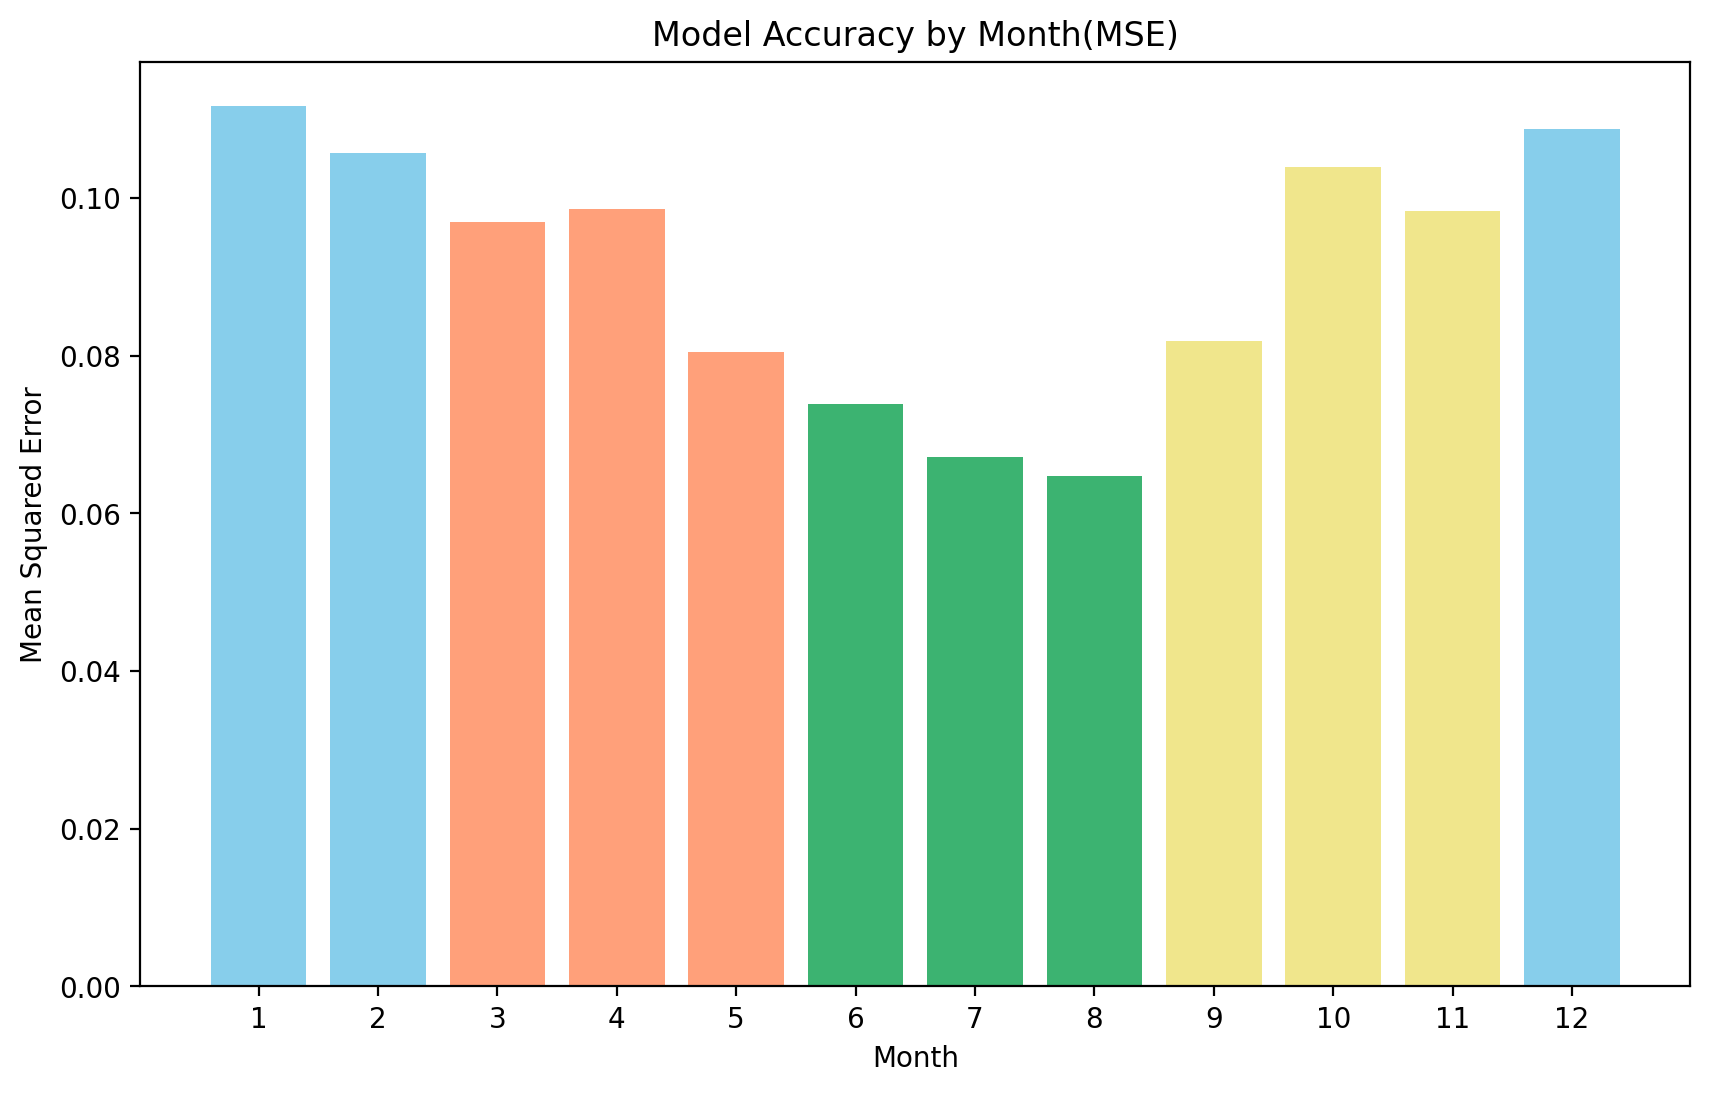

In [27]:
plt.figure(figsize=(10, 6))
for index, row in monthly_mse.iterrows():
    plt.bar(row['month'], row['MSE'], color=season_colors[row['month']])
plt.xlabel('Month')
plt.ylabel('Mean Squared Error')
plt.title('Model Accuracy by Month(MSE)')
plt.xticks(monthly_mse['month'], labels=[f'{m}' for m in monthly_mse['month']])
plt.show()

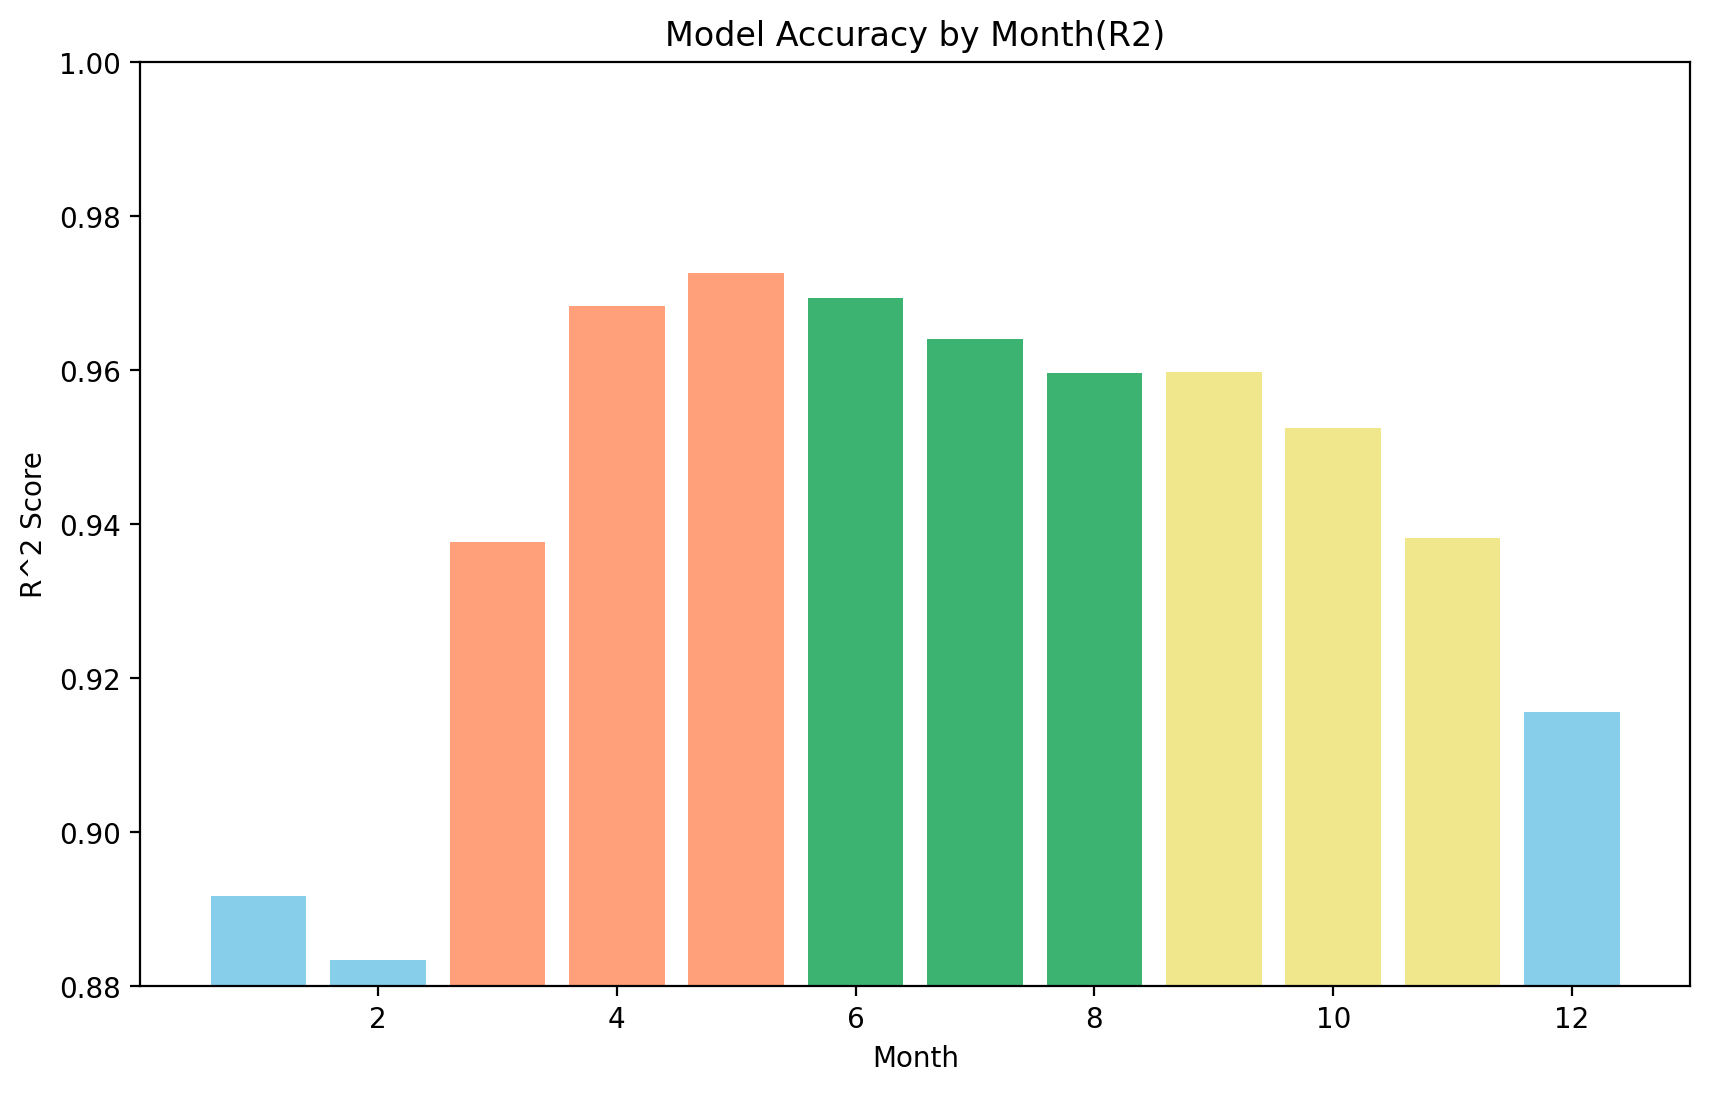

In [28]:
monthly_r2 = test_mean.groupby('month').apply(lambda x: r2_score(x['TREFMXAV_U'], x['predict']))
monthly_r2 = monthly_r2.reset_index().rename(columns={0: 'R2'})

plt.figure(figsize=(10, 6))
#plt.bar(monthly_r2['month'], monthly_r2['R2'], color='skyblue')
for index, row in monthly_r2.iterrows():
    plt.bar(row['month'], row['R2'], color=season_colors[row['month']])
plt.xlabel('Month')
plt.ylabel('R^2 Score')
plt.title('Model Accuracy by Month(R2)')
plt.ylim(0.88, 1.0)
plt.show()

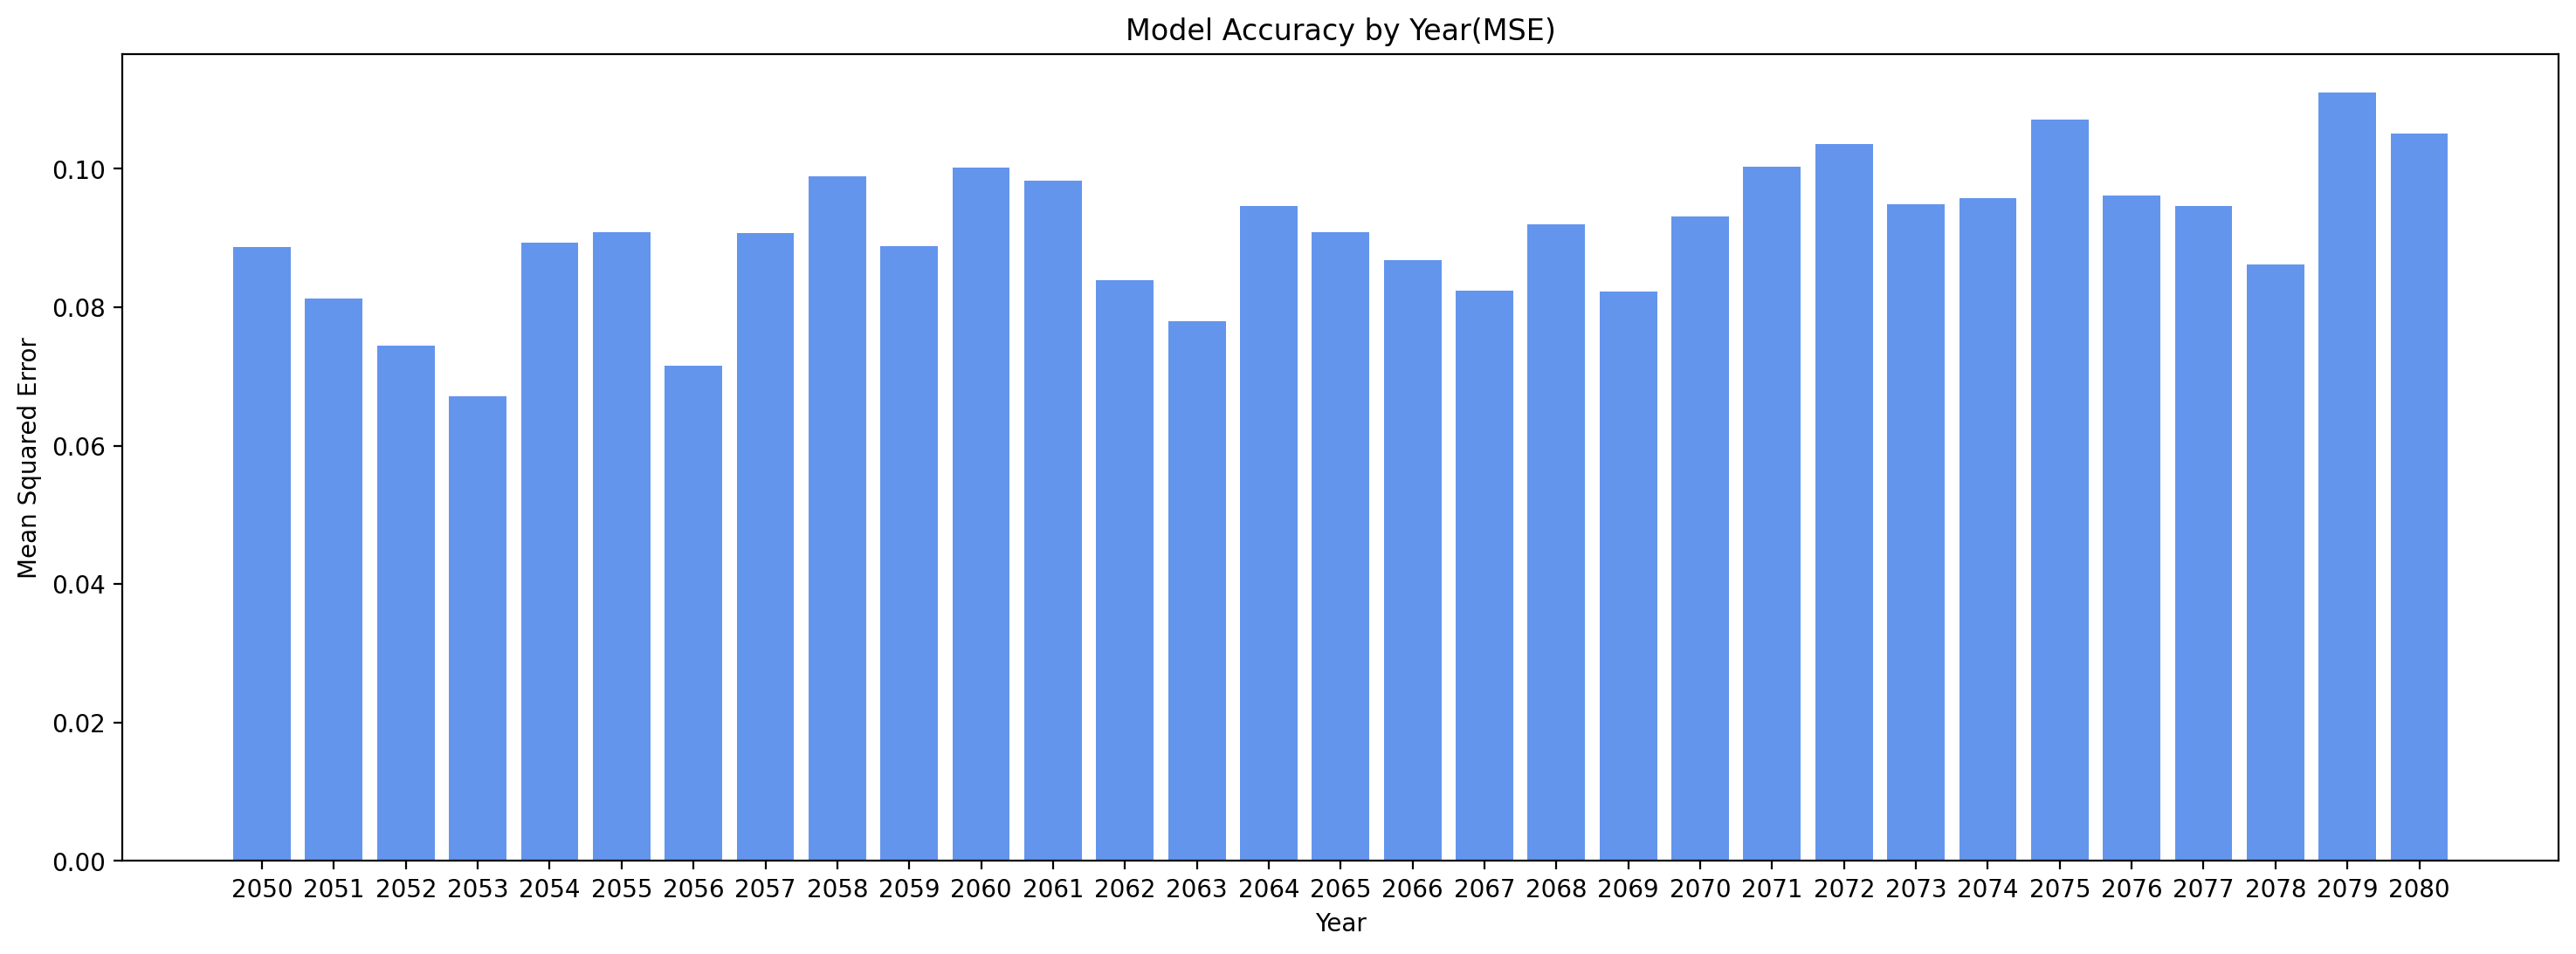

In [29]:
yearly_mse = test_mean.groupby('year').apply(lambda x: mean_squared_error(x['TREFMXAV_U'], x['predict']))
yearly_mse = yearly_mse.reset_index().rename(columns={0: 'MSE'})

plt.figure(figsize=(18, 6))
plt.bar(yearly_mse['year'], yearly_mse['MSE'], color='cornflowerblue')
plt.xlabel('Year')
plt.ylabel('Mean Squared Error')
plt.title('Model Accuracy by Year(MSE)')
plt.xticks(yearly_mse['year'], labels=[f'{m}' for m in yearly_mse['year']])
plt.show()

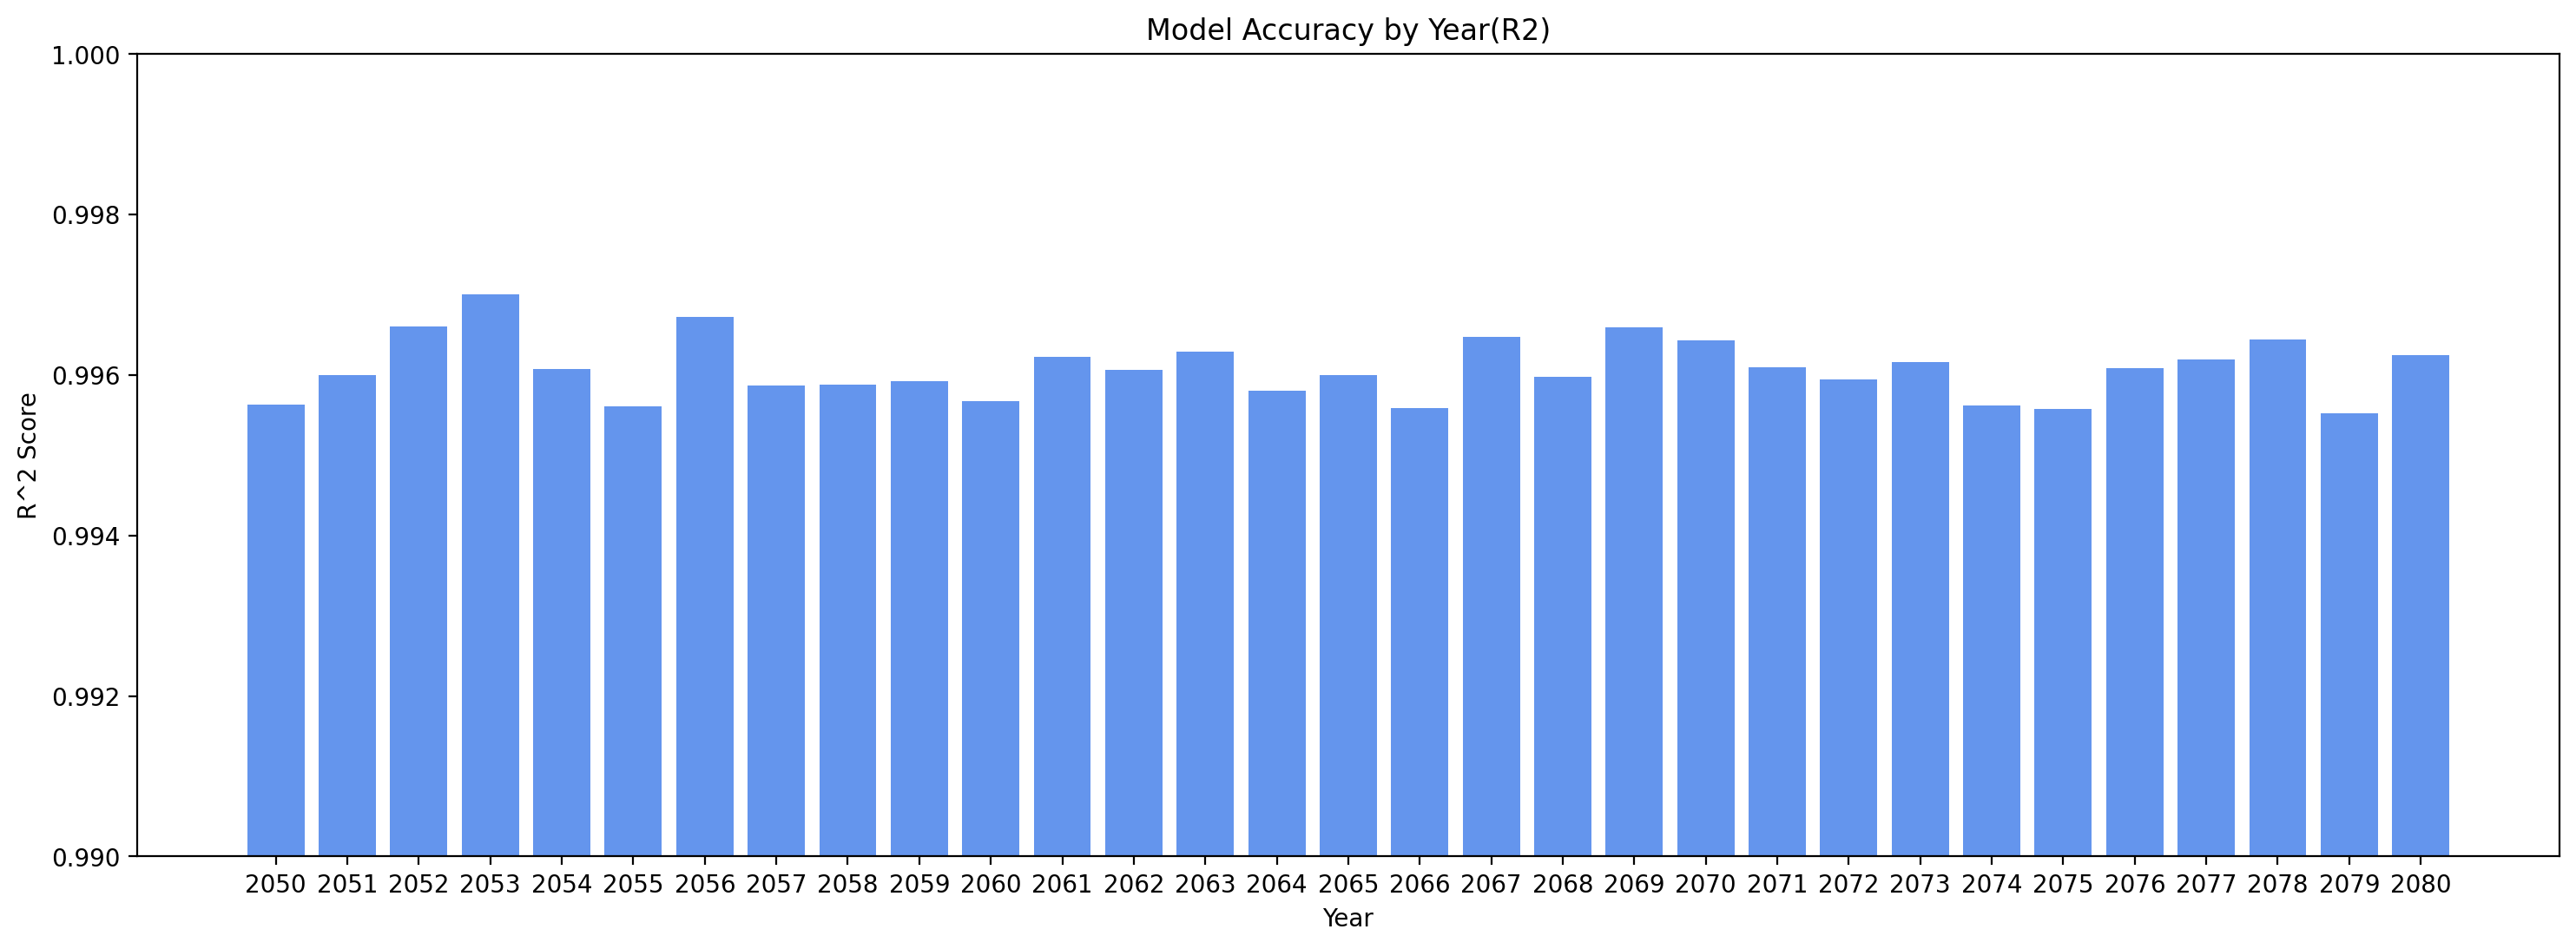

In [30]:
yearly_r2 = test_mean.groupby('year').apply(lambda x: r2_score(x['TREFMXAV_U'], x['predict']))
yearly_r2 = yearly_r2.reset_index().rename(columns={0: 'R2'})

plt.figure(figsize=(18, 6))
plt.bar(yearly_r2['year'], yearly_r2['R2'], color='cornflowerblue')
plt.xlabel('Year')
plt.ylabel('R^2 Score')
plt.title('Model Accuracy by Year(R2)')
plt.xticks(yearly_r2['year'], labels=[f'{m}' for m in yearly_r2['year']])
plt.ylim(0.99, 1.0)
plt.show()

compare different source

In [31]:
X_test_3 = test_3.drop(['TREFMXAV_U','source','time'], axis=1)
X_test_4 = test_4.drop(['TREFMXAV_U','source','time'], axis=1) 
X_test_5 = test_5.drop(['TREFMXAV_U','source','time'], axis=1) 
X_test_6 = test_6.drop(['TREFMXAV_U','source','time'], axis=1) 
X_test_7 = test_7.drop(['TREFMXAV_U','source','time'], axis=1) 
X_test_8 = test_8.drop(['TREFMXAV_U','source','time'], axis=1) 

In [32]:
y_pred_3 = automl.predict(X_test_3)

test_3['predict'] = y_pred_3

y_test_3 = test_3['TREFMXAV_U']
y_test_3_pred = test_3['predict']

mse_3 = mean_squared_error(y_test_3, y_test_3_pred)
r2_3 = r2_score(y_test_3, y_test_3_pred)

print(f'Validation Mean Squared Error (MSE): {mse_3}')
print(f'Validation R-squared: {r2_3}')

Validation Mean Squared Error (MSE): 0.4962819856045813
Validation R-squared: 0.9838502780624855


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\1467859906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_3['predict'] = y_pred_3


In [33]:
y_pred_4 = automl.predict(X_test_4)

test_4['predict'] = y_pred_4

y_test_4 = test_4['TREFMXAV_U']
y_test_4_pred = test_4['predict']

mse_4 = mean_squared_error(y_test_4, y_test_4_pred)
r2_4 = r2_score(y_test_4, y_test_4_pred)

print(f'Validation Mean Squared Error (MSE): {mse_4}')
print(f'Validation R-squared: {r2_4}')

Validation Mean Squared Error (MSE): 0.4863394680652352
Validation R-squared: 0.9828732390980226


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\3489715666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_4['predict'] = y_pred_4


In [34]:
y_pred_5 = automl.predict(X_test_5)

test_5['predict'] = y_pred_5

y_test_5 = test_5['TREFMXAV_U']
y_test_5_pred = test_5['predict']

mse_5 = mean_squared_error(y_test_5, y_test_5_pred)
r2_5 = r2_score(y_test_5, y_test_5_pred)

print(f'Validation Mean Squared Error (MSE): {mse_5}')
print(f'Validation R-squared: {r2_5}')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\477929802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_5['predict'] = y_pred_5


Validation Mean Squared Error (MSE): 0.4837621835821855
Validation R-squared: 0.9831540287517225


In [35]:
y_pred_6 = automl.predict(X_test_6)

test_6['predict'] = y_pred_6

y_test_6 = test_6['TREFMXAV_U']
y_test_6_pred = test_6['predict']

mse_6 = mean_squared_error(y_test_6, y_test_6_pred)
r2_6 = r2_score(y_test_6, y_test_6_pred)

print(f'Validation Mean Squared Error (MSE): {mse_6}')
print(f'Validation R-squared: {r2_6}')

Validation Mean Squared Error (MSE): 0.5083297304152004
Validation R-squared: 0.982405433499857


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\2764301018.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_6['predict'] = y_pred_6


In [36]:
y_pred_7 = automl.predict(X_test_7)

test_7['predict'] = y_pred_7

y_test_7 = test_7['TREFMXAV_U']
y_test_7_pred = test_7['predict']

mse_7 = mean_squared_error(y_test_7, y_test_7_pred)
r2_7 = r2_score(y_test_7, y_test_7_pred)

print(f'Validation Mean Squared Error (MSE): {mse_7}')
print(f'Validation R-squared: {r2_7}')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\619159630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_7['predict'] = y_pred_7


Validation Mean Squared Error (MSE): 0.49774978500895034
Validation R-squared: 0.9832316945479114


In [37]:
y_pred_8 = automl.predict(X_test_8)

test_8['predict'] = y_pred_8

y_test_8 = test_8['TREFMXAV_U']
y_test_8_pred = test_8['predict']

mse_8 = mean_squared_error(y_test_8, y_test_8_pred)
r2_8 = r2_score(y_test_8, y_test_8_pred)

print(f'Validation Mean Squared Error (MSE): {mse_8}')
print(f'Validation R-squared: {r2_8}')

Validation Mean Squared Error (MSE): 0.5069616318327826
Validation R-squared: 0.9824401671520475


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\2582664114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_8['predict'] = y_pred_8


In [38]:
data_accuracy = {
    'Source':['source3','source4','source5','source6','source7','source8'],
    'MSE':[  mse_3, mse_4, mse_5, mse_6, mse_7, mse_8],
    'r2':[  r2_3, r2_4, r2_5, r2_6, r2_7, r2_8]
}
df_accuracy = pd.DataFrame(data_accuracy)

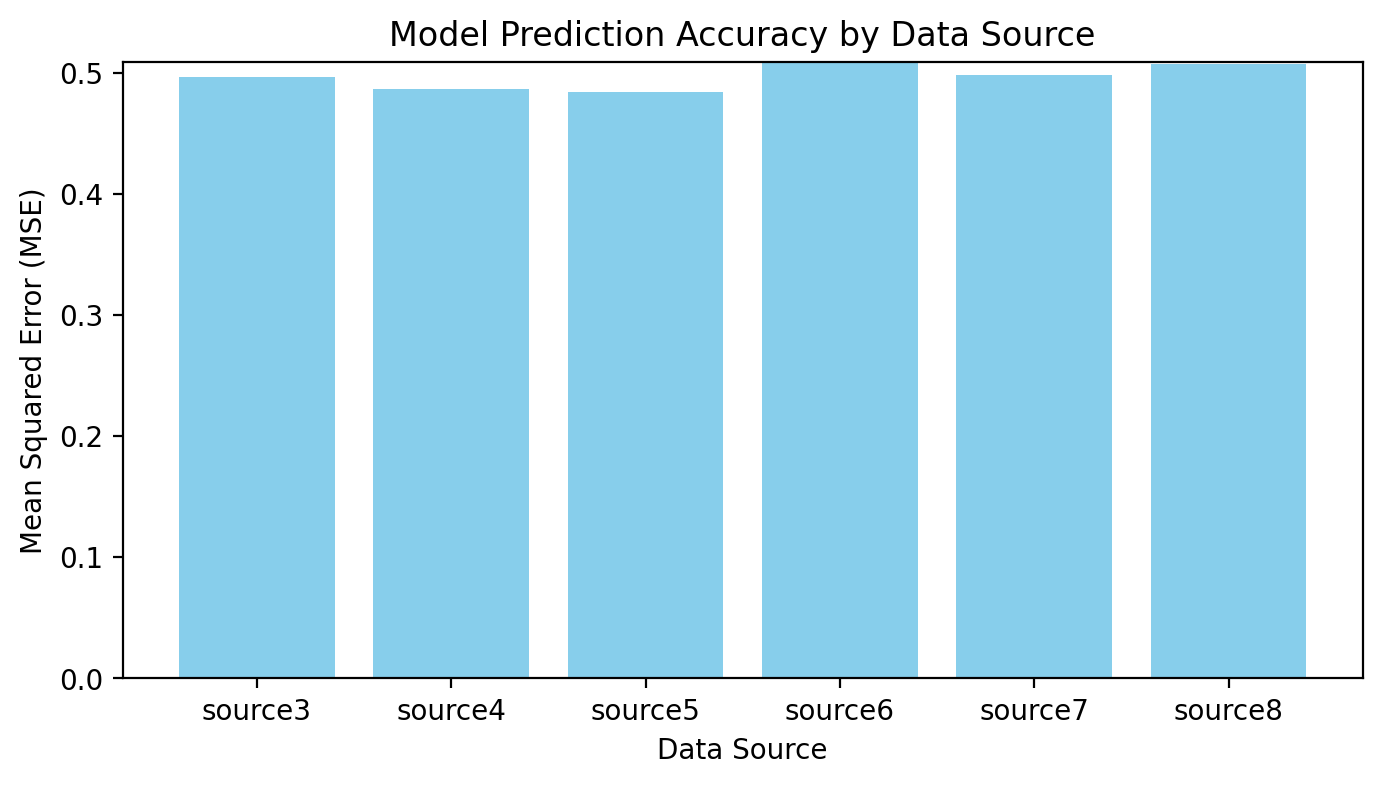

In [39]:
plt.figure(figsize=(8, 4))
plt.bar(df_accuracy['Source'], df_accuracy['MSE'], color='skyblue')
plt.xlabel('Data Source')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Prediction Accuracy by Data Source')
plt.ylim(0, max(df_accuracy['MSE']) + 0.00005)  
plt.show()

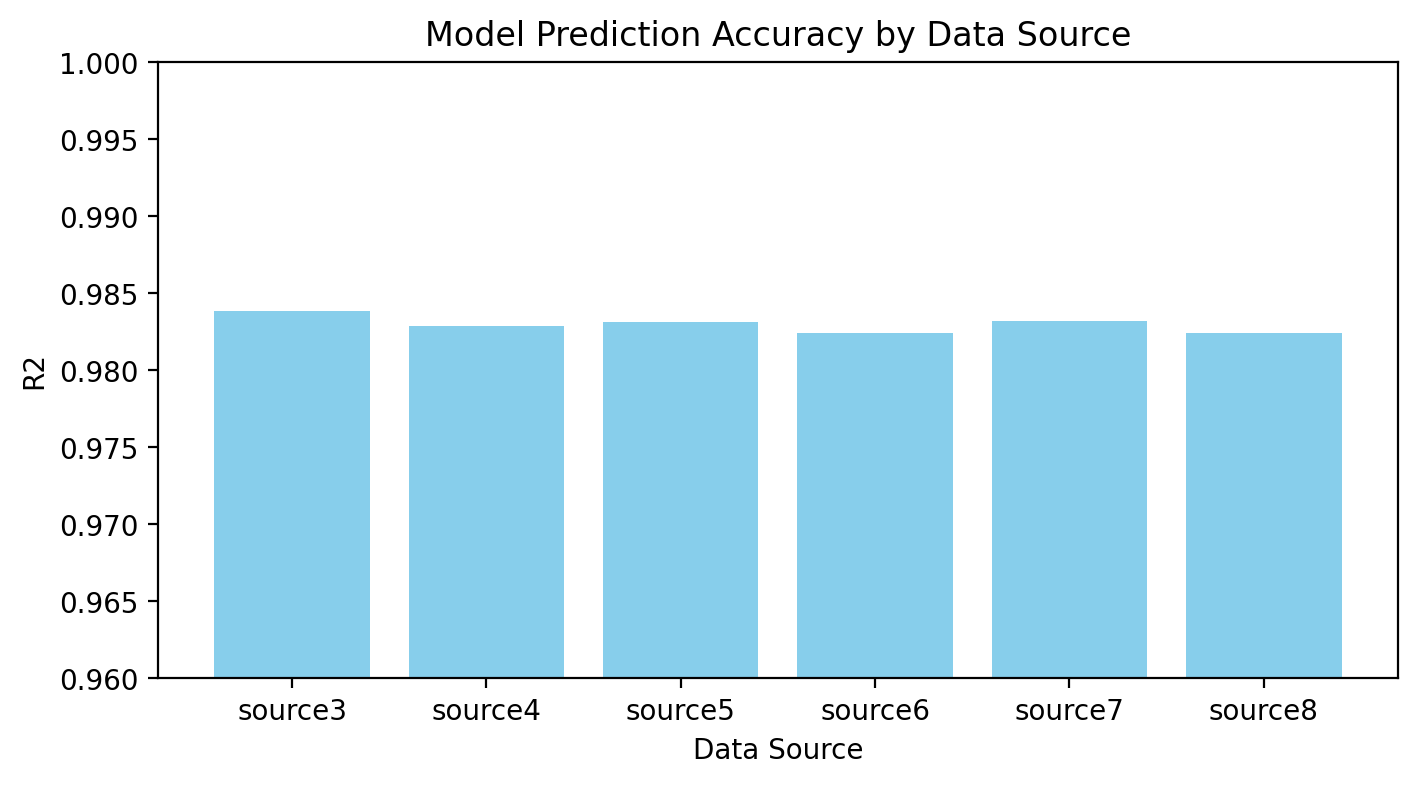

In [40]:
plt.figure(figsize=(8, 4))
plt.bar(df_accuracy['Source'], df_accuracy['r2'], color='skyblue')
plt.xlabel('Data Source')
plt.ylabel('R2')
plt.title('Model Prediction Accuracy by Data Source')
plt.ylim(0.96, 1.0)
plt.show()

Location

In [42]:
lat = 50.418850
lon = 357.5
ds_sw = combined_dataset.sel(lat = lat, lon = lon, method = 'nearest')
#turn to dataframe
df_sw = ds_sw.to_dataframe().reset_index()
df_sw = df_sw.drop(['lat', 'lon'], axis=1)
#deal with time information
df_sw['time'] = df_sw['time'].astype(str)
df_sw['time'] = pd.to_datetime(df_sw['time'])
#Split time to year, month, day of year
df_sw['year'] = df_sw['time'].dt.year
df_sw['month'] = df_sw['time'].dt.month
df_sw['dayofyear'] = df_sw['time'].dt.dayofyear

#change source name
df_sw['source'] = df_sw['source'].str.split('_').str[0]
df_sw['source'] = df_sw['source'].astype(int)



test_sw = df_sw[df_sw['time'].dt.year >= 2050]
X_sw_test = test_sw.drop(['TREFMXAV_U','source','time'], axis=1) 

y_sw_pred = automl.predict(X_sw_test)

test_sw['predict'] = y_sw_pred
test_sw_mean = test_sw.groupby('time').mean().reset_index()
test_sw_mean = test_sw_mean.drop(['source'], axis=1)

y_sw_test_mean = test_sw_mean['TREFMXAV_U']
y_sw_test_pred = test_sw_mean['predict']

r2_sw = r2_score(y_sw_test_mean, y_sw_test_pred)

print(f'AutoML R-squared: {r2_sw}')

AutoML R-squared: 0.6752815383383679


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\2576860783.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sw['predict'] = y_sw_pred


In [44]:
lat = 57.958115
lon = 356.25
ds_sw = combined_dataset.sel(lat = lat, lon = lon, method = 'nearest')
#turn to dataframe
df_sw = ds_sw.to_dataframe().reset_index()
df_sw = df_sw.drop(['lat', 'lon'], axis=1)
#deal with time information
df_sw['time'] = df_sw['time'].astype(str)
df_sw['time'] = pd.to_datetime(df_sw['time'])
#Split time to year, month, day of year
df_sw['year'] = df_sw['time'].dt.year
df_sw['month'] = df_sw['time'].dt.month
df_sw['dayofyear'] = df_sw['time'].dt.dayofyear

#change source name
df_sw['source'] = df_sw['source'].str.split('_').str[0]
df_sw['source'] = df_sw['source'].astype(int)


test_sw = df_sw[df_sw['time'].dt.year >= 2050]
X_sw_test = test_sw.drop(['TREFMXAV_U','source','time'], axis=1) 


y_sw_pred = automl.predict(X_sw_test)


test_sw['predict'] = y_sw_pred
test_sw_mean = test_sw.groupby('time').mean().reset_index()
test_sw_mean = test_sw_mean.drop(['source'], axis=1)

y_sw_test_mean = test_sw_mean['TREFMXAV_U']
y_sw_test_pred = test_sw_mean['predict']

r2_sw = r2_score(y_sw_test_mean, y_sw_test_pred)

print(f'AutoML R-squared: {r2_sw}')

AutoML R-squared: 0.9929994870493887


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\3979720422.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sw['predict'] = y_sw_pred


QBOT

In [45]:
qbot_min = test_mean['QBOT'].min()
qbot_max = test_mean['QBOT'].max()
qbot_bins = np.linspace(qbot_min, qbot_max, num=11)

In [46]:
test_mean['qbot_bin'] = pd.cut(test_mean['QBOT'], bins=qbot_bins, labels=np.arange(1, 11), include_lowest=True)

In [47]:
qbot_mse = test_mean.groupby('qbot_bin').apply(lambda x: mean_squared_error(x['TREFMXAV_U'], x['predict']))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16144\265957056.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  qbot_mse = test_mean.groupby('qbot_bin').apply(lambda x: mean_squared_error(x['TREFMXAV_U'], x['predict']))


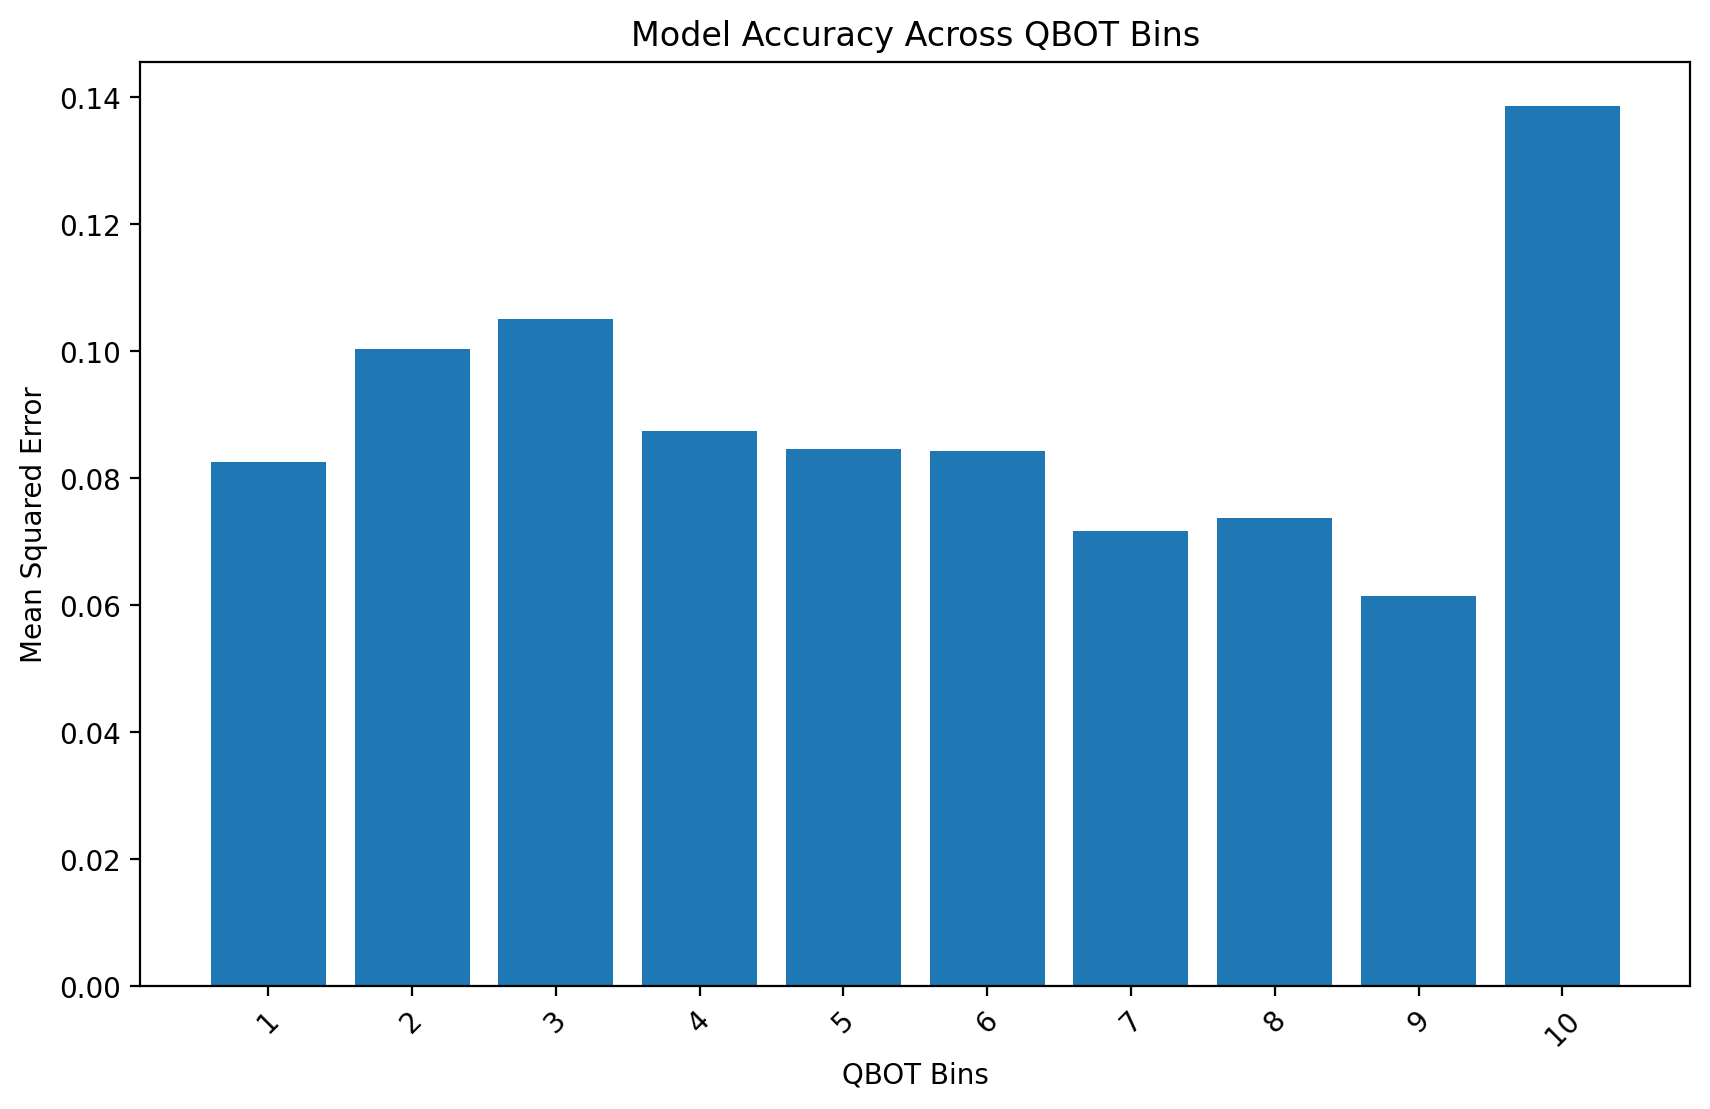

In [48]:
plt.figure(figsize=(10, 6))
plt.bar(qbot_mse.index.astype(str), qbot_mse.values)
plt.xlabel('QBOT Bins')
plt.ylabel('Mean Squared Error')
plt.title('Model Accuracy Across QBOT Bins')
plt.xticks(rotation=45)
plt.show()

project reflection:
 
In this project, I used 6 sets of UK meteorological data to model and predict the Urban daily maximum of average 2-m temperature for Manchester from 2050 to 2080. During the model building process, I used AutoML to tune the hyperparameters of the model, resulting in an overall predicted Mean Squared Error (MSE) of 4.9121847989880246e-05 and an R-squared of 0.9966554055320338. In addition, I compared the accuracy of the model across months and years. Also compared the accuracy of the model with different data sources.

However, the modelling is based on one city, Manchester, which leads to poor application of the model to the remaining cities. Subsequently, consideration needs to be given to incorporating coordinates into the model parameters to increase the breadth of model application.